# Step 0: Defining Model Class

In [1]:
# Basics
import pandas as pd
import numpy as np

#Plotting
from matplotlib import pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
plt.style.use('ggplot')

# Warnings
import warnings
warnings.filterwarnings('ignore')

#Auto ARIMA
try:
    from pmdarima.arima import auto_arima
except:
    ! pip install pmdarima
    from pmdarima.arima import auto_arima

# Import statsmodels api
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Tools for saving the model
import pickle
from bz2 import BZ2File

class Model(object):
    
    def __init__(self, test_size=36, predict_size=24, start_date='2012-01-01'):
        self.model_dictionary = {}
        self.test_size = test_size
        self.predict_size = predict_size
        self.start_date = start_date
        
    def build_model(self):
        try:
            with BZ2File('modelArchive.bz2', 'rb') as file:
                self.model_dictionary = pickle.load(file)
        except:
            print("File not found. Building model.")
            zip_codes = self.model_dictionary.keys()
            N = len(zip_codes)
            for ind, zip_code in enumerate(zip_codes):
                self.fit(zip_code, trace=False)
                self.predict(zip_code)
                self.forecast(zip_code)
                self.compute_roi(zip_code)
                print(f'Finished processing {ind+1} out of {N} zip codes.')
            with BZ2File('modelArchive.bz2', 'wb') as file:
                pickle.dump(self.model_dictionary, file)
    
    # Load data from data frame
    def load_data(self, df):
        self._make_datetime_index(df)
        for ind in df.index.values:
            row = df.loc[ind]
            zip_code = self._get_zip_code(row)
            row_dict = self._make_row_dict(row)
            self.model_dictionary[zip_code] = row_dict
    
    def _make_datetime_index(self, df):
        string_index = df.columns.values[8:]
        self.datetime_index = pd.to_datetime(string_index)
            
    def _get_zip_code(self, row):
        return row['RegionName']
            
    def _make_row_dict(self, row):
        row_dict = row.iloc[1:8].to_dict()
        time_series = row.iloc[8:]
        df = self._make_time_series_df(time_series)
        df = df.fillna(df.bfill())
        row_dict['TimeSeries'] = df
        return row_dict
      
    def _make_time_series_df(self, time_series):
        time_series.index = self.datetime_index
        df = pd.DataFrame(time_series, dtype=float)
        df.columns = ['MedianSales']
        return df
    
    def get_time_series(self, zip_code):
        return self.model_dictionary[zip_code]['TimeSeries'][self.start_date:]
    
    def get_city_name(self, zip_code):
        return self.model_dictionary[zip_code]['City']
    
    def get_state_abbreviation(self, zip_code):
        return self.model_dictionary[zip_code]['State']
    
    # Train Test Split    
    def get_train_test_split(self, zip_code):
        time_series_df = self.get_time_series(zip_code)
        train = time_series_df[:-self.test_size]
        test = time_series_df[-self.test_size:]
        return train, test
    
    # Plotting
    def time_series_plot(self, zip_code, show_prediction=True, show_forecast=True):
        fig, ax = plt.subplots(figsize=(8, 5));
        self._time_series_plot_train_test_ax(zip_code, ax)
        legend_labels = ['Train', 'Test']
        if show_prediction:
            self._time_series_plot_prediction_ax(zip_code, ax)
            legend_labels.append('Prediction')
        if show_forecast:
            self._time_series_plot_forcast_ax(zip_code, ax)
            legend_labels.append('Forecast')
        self._time_series_plot_annotate(zip_code, ax, legend_labels)
        return fig
    
    def _time_series_plot_train_test_ax(self, zip_code, ax):
        train, test = self.get_train_test_split(zip_code)
        ax.plot(train);
        ax.plot(test);
        
    def _time_series_plot_prediction_ax(self, zip_code, ax):
        prediction = self.predict(zip_code)
        ax.plot(prediction['mean'])
        ax.fill_between(
            prediction.index,
            prediction['mean_ci_lower'],
            prediction['mean_ci_upper'],
            color = 'g',
            alpha = 0.5
        )
    def _time_series_plot_forcast_ax(self, zip_code, ax):
        forecast = self.forecast(zip_code)
        ax.plot(forecast['mean'])
        ax.fill_between(
            forecast.index,
            forecast['mean_ci_lower'],
            forecast['mean_ci_upper'],
            color = 'g',
            alpha = 0.5
        )
        
        
    def _time_series_plot_annotate(self, zip_code, ax, legend_labels):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        ax.set_title(f'Median Sale Price {city_name}, {state_abbreviation} {zip_code}')
        ax.set_xlabel('Date')
        ax.set_ylabel('Price')
        ax.legend(legend_labels);
        
    def acf_plot(self, zip_code):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        train, test = self.get_train_test_split(zip_code)
        fig, ax = plt.subplots(figsize=(8,5));
        plot_acf(
            x=train, 
            ax=ax, 
            lags=24,
            title=f'Autocorrelation for {city_name}, {state_abbreviation} {zip_code}'
        );
        return fig
    
    def pacf_plot(self, zip_code):
        city_name = self.get_city_name(zip_code)
        state_abbreviation = self.get_state_abbreviation(zip_code)
        train, test = self.get_train_test_split(zip_code)
        fig, ax = plt.subplots(figsize=(8,5));
        plot_pacf(
            x=train, 
            ax=ax, 
            lags=24,
            title=f'Partial Autocorrelation for {city_name}, {state_abbreviation} {zip_code}'
        );
        return fig
    
    # Model Selection
    def fit(self, zip_code, trace=True):
        try:
            best_model = self.model_dictionary[zip_code]['BestModel']
        except:
            y = self.get_time_series(zip_code)
            model = auto_arima(
                y = y,
                X=None,
                start_p=0,
                d=1,
                start_q=0,
                max_p=2,
                max_d=2,
                max_q=2,
                start_P=0,
                D=1,
                start_Q=0,
                max_P=2,
                max_D=2,
                max_Q=2,
                max_order=None,
                m=12,
                seasonal=True,
                stationary=False,
                information_criterion='oob',
                alpha=0.05,
                test='kpss',
                seasonal_test='OCSB',
                stepwise=True,            
                suppress_warnings=True,
                error_action='warn',
                trace=trace,
                out_of_sample_size= self.test_size,
                scoring='mse'
            )
            order = model.order
            seasonal_order = model.seasonal_order
            trend = model.trend
            best_model = SARIMAX(
                endog=y,
                order=order,
                seasonal_order=seasonal_order,
                enforce_stationarity=False,
                enforce_invertibility=False
            ).fit()
            self.model_dictionary[zip_code]['BestModel'] = best_model
        return best_model
    
    # Model Validation
    def predict(self, zip_code):
        try:
            prediction = self.model_dictionary[zip_code]['Prediction']
        except:
            model = self.fit(zip_code)
            prediction = model.get_prediction().summary_frame()
            self.model_dictionary[zip_code]['Prediction'] = prediction
        return prediction
    
    def plot_diagnostics(self, zip_code):
        best_model = self.fit(zip_code)
        city = self.get_city_name(zip_code)
        state = self.get_state_abbreviation(zip_code)
        fig = best_model.plot_diagnostics(figsize=(16, 10));
        fig.suptitle(f'Diagnostics for {city}, {state} {zip_code}', fontsize=16)
        return fig
    
    # Predict future prices
    def forecast(self, zip_code):
        try:
            forecast = self.model_dictionary[zip_code]['Forecast']
        except:
            model = self.fit(zip_code)
            forecast = model.get_forecast(steps=self.predict_size).summary_frame()
            self.model_dictionary[zip_code]['Forecast'] = forecast
        return forecast
    
    # Compute ROI
    def compute_roi(self, zip_code):
        try:
            roi = self.model_dictionary[zip_code]['ROI']
        except:
            initial_price = self.get_time_series(zip_code)['MedianSales'][-1]
            final_price = self.forecast(zip_code)['mean'][-1]
            roi = (final_price-initial_price)/initial_price
            self.model_dictionary[zip_code]['ROI'] = roi
        return roi
    
    # Select top 5 zip codes by ROI
    def roi_dict(self):
        roi_dict = {key: value['ROI'] for key, value in self.model_dictionary.items()}
        return roi_dict

# Step 1: Import the Data
Our main data set is stored in the `zillow_data.csv` spreadsheet. We load the CSV file as a data frame below.

In [2]:
df = pd.read_csv('../data/ZHVI.csv.gz', index_col='RegionID', compression='gzip')
print(df.shape)
df.head()

(30205, 306)


,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
RegionID,,,,,,,,,,,,,,,,,,,,,
61639,0,10025,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,...,930560.0,932099.0,933253.0,930160.0,926279.0,920531.0,919481.0,920766.0,927266.0,932302.0
84654,1,60657,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,296113.0,295520.0,...,786707.0,787854.0,789482.0,790451.0,790939.0,791300.0,793322.0,796143.0,801148.0,806603.0
61637,2,10023,Zip,NY,NY,New York,New York-Newark-Jersey City,New York County,NaN,NaN,...,1290836.0,1291613.0,1288723.0,1283261.0,1278518.0,1279537.0,1279105.0,1280177.0,1282240.0,1289935.0
91982,3,77494,Zip,TX,TX,Katy,Houston-The Woodlands-Sugar Land,Harris County,203140.0,203391.0,...,340112.0,340320.0,340828.0,341998.0,343077.0,343858.0,344397.0,345495.0,346575.0,348416.0
84616,4,60614,Zip,IL,IL,Chicago,Chicago-Naperville-Elgin,Cook County,462086.0,461720.0,...,1010879.0,1012589.0,1014209.0,1015467.0,1015662.0,1017251.0,1020360.0,1023859.0,1029882.0,1036427.0


We will restrict our attention to the city of Baltimore, so we filter the data below.

In [3]:
df = df.query("City == 'Baltimore' and State == 'MD'")
print(df.shape)
df.head()

(20, 306)


,SizeRank,RegionName,RegionType,StateName,State,City,Metro,CountyName,1996-01-31,1996-02-29,...,2020-01-31,2020-02-29,2020-03-31,2020-04-30,2020-05-31,2020-06-30,2020-07-31,2020-08-31,2020-09-30,2020-10-31
RegionID,,,,,,,,,,,,,,,,,,,,,
66825,368,21215,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,80880.0,80666.0,...,141847.0,142485.0,142719.0,143417.0,143771.0,143966.0,144283.0,145614.0,147702.0,150608.0
66834,484,21224,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,93965.0,93858.0,...,181401.0,181205.0,181259.0,181296.0,181779.0,182020.0,182601.0,183819.0,186429.0,189625.0
66828,744,21218,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,71417.0,71853.0,...,158316.0,158647.0,159052.0,159753.0,160528.0,160478.0,160820.0,161670.0,164124.0,166767.0
66816,783,21206,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,82607.0,82660.0,...,157113.0,156408.0,155997.0,155919.0,156004.0,155849.0,156458.0,158033.0,160752.0,163549.0
66839,1088,21229,Zip,MD,MD,Baltimore,Baltimore-Columbia-Towson,Baltimore City,82654.0,82794.0,...,120521.0,121307.0,121899.0,122483.0,123296.0,124109.0,125143.0,126557.0,129136.0,131301.0


# Step 2: Instantiate the Model and Load in the Data
Below we instantiate a Model object and load our selected data into the object.

In [4]:
model = Model()
model.load_data(df)

# Step 3: EDA and Visualization
Below we display a time series plot, ACF plot, and PACF plot for the zip code 21215. The class methods used below will work for any zip code in our model.

In [5]:
zip_code = 21215

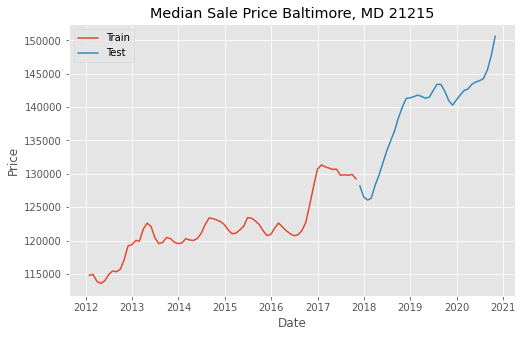

In [6]:
model.time_series_plot(zip_code, show_prediction=False, show_forecast=False);

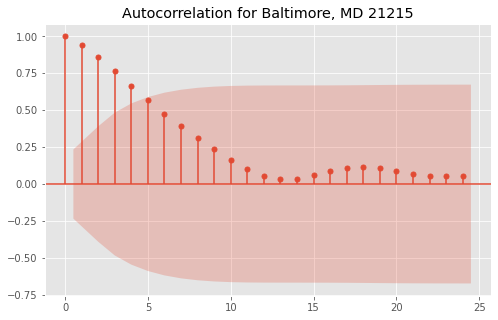

In [7]:
model.acf_plot(zip_code);

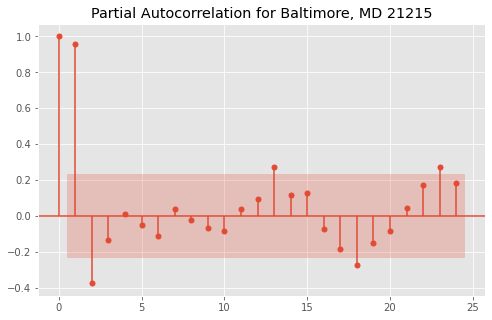

In [8]:
model.pacf_plot(zip_code);

# Step 4: ARIMA Modeling
Below we select the best ARIMA model for our example zip code.

In [9]:
best_model = model.fit(zip_code)

Performing stepwise search to minimize oob
 ARIMA(0,1,0)(0,1,0)[12]             : OOB=21009007.500, Time=0.09 sec
 ARIMA(1,1,0)(1,1,0)[12]             : OOB=21730401.652, Time=0.19 sec
 ARIMA(0,1,1)(0,1,1)[12]             : OOB=21863691.896, Time=0.34 sec
 ARIMA(0,1,0)(1,1,0)[12]             : OOB=21039222.247, Time=0.27 sec
 ARIMA(0,1,0)(0,1,1)[12]             : OOB=21034073.782, Time=0.15 sec
 ARIMA(0,1,0)(1,1,1)[12]             : OOB=inf, Time=0.49 sec
 ARIMA(1,1,0)(0,1,0)[12]             : OOB=21528076.989, Time=0.12 sec
 ARIMA(0,1,1)(0,1,0)[12]             : OOB=21564544.421, Time=0.15 sec
 ARIMA(1,1,1)(0,1,0)[12]             : OOB=21673588.104, Time=0.12 sec
 ARIMA(0,1,0)(0,1,0)[12] intercept   : OOB=25401782.806, Time=0.06 sec

Best model:  ARIMA(0,1,0)(0,1,0)[12]          
Total fit time: 2.005 seconds


# Step 5: Model Validation
Below we make an in sample prediction using our best model, display the prediction with the actual data, and display diagnostic plots for the fit.

In [10]:
model.predict(zip_code)

MedianSales,mean,mean_se,mean_ci_lower,mean_ci_upper
2012-01-31,0.0,1732.050808,-3394.757202,3394.757202
2012-02-29,114800.0,1938.069054,111001.454455,118598.545545
2012-03-31,114915.0,1938.069054,111116.454455,118713.545545
2012-04-30,113877.0,1938.069054,110078.454455,117675.545545
2012-05-31,113573.0,1938.069054,109774.454455,117371.545545
...,...,...,...,...
2020-06-30,144731.0,1660.154106,141477.157743,147984.842257
2020-07-31,144935.0,1660.154106,141681.157743,148188.842257
2020-08-31,144258.0,1660.154106,141004.157743,147511.842257
2020-09-30,144593.0,1660.154106,141339.157743,147846.842257


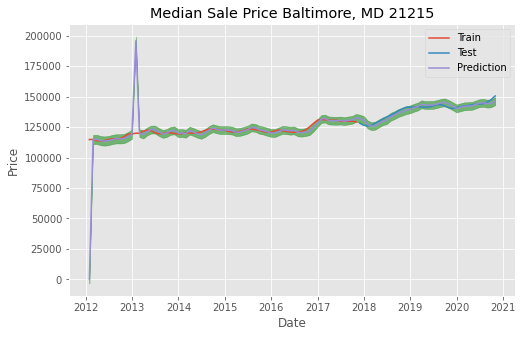

In [11]:
model.time_series_plot(zip_code, show_forecast=False);

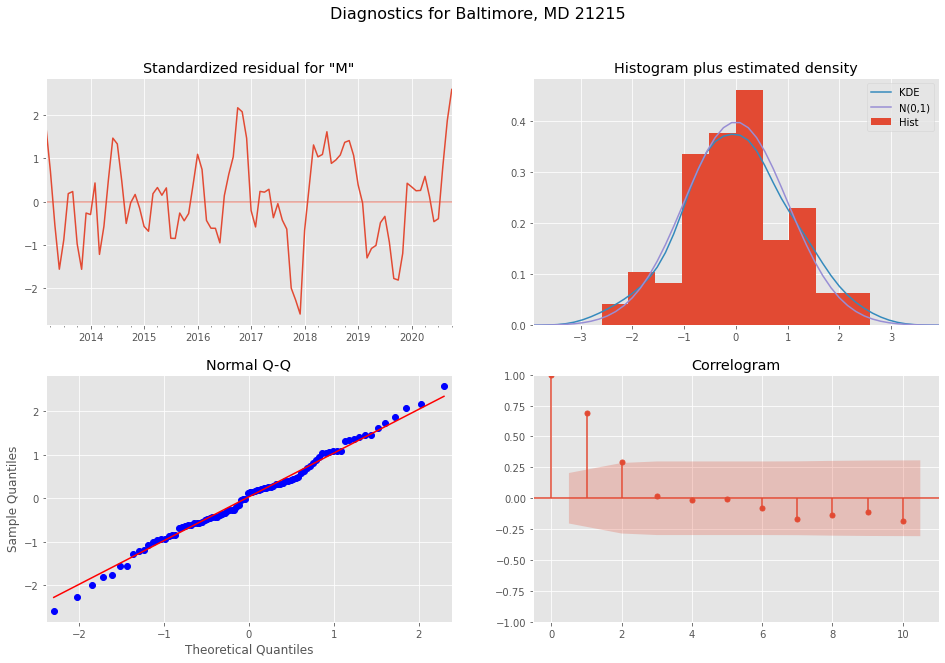

In [12]:
model.plot_diagnostics(zip_code);

# Step 6: Making a Forecast
Below we forecast into the future, make a final time series plot which includes our forecast, and compute our expected return on investment for the example zip code.

In [13]:
model.forecast(zip_code)

MedianSales,mean,mean_se,mean_ci_lower,mean_ci_upper
2020-11-30,149917.0,1660.154106,146663.157743,153170.842257
2020-12-31,150703.0,2347.812453,146101.372150,155304.627850
2021-01-31,151468.0,2875.471261,145832.179891,157103.820109
2021-02-28,152106.0,3320.308213,145598.315486,158613.684514
2021-03-31,152340.0,3712.217435,145064.187525,159615.812475
2021-04-30,153038.0,4066.530455,145067.746766,161008.253234
2021-05-31,153392.0,4392.354903,144783.142582,162000.857418
2021-06-30,153587.0,4695.624906,144383.744300,162790.255700
2021-07-31,153904.0,4980.462319,144142.473229,163665.526771
2021-08-31,155235.0,5249.868243,144945.447320,165524.552680


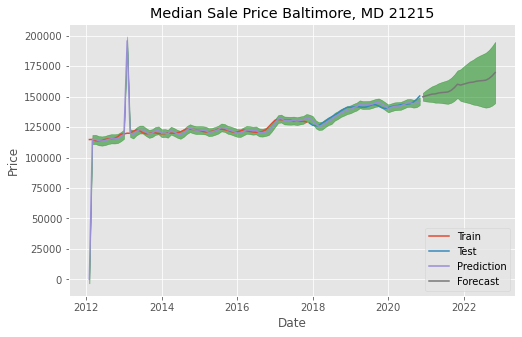

In [14]:
model.time_series_plot(zip_code);

In [15]:
model.compute_roi(zip_code)

0.12776213746945714

# Step 7: Building the Model

In [16]:
model.build_model()

File not found. Building model.
Finished processing 1 out of 20 zip codes.
Finished processing 2 out of 20 zip codes.
Finished processing 3 out of 20 zip codes.
Finished processing 4 out of 20 zip codes.
Finished processing 5 out of 20 zip codes.
Finished processing 6 out of 20 zip codes.
Finished processing 7 out of 20 zip codes.
Finished processing 8 out of 20 zip codes.
Finished processing 9 out of 20 zip codes.
Finished processing 10 out of 20 zip codes.
Finished processing 11 out of 20 zip codes.
Finished processing 12 out of 20 zip codes.
Finished processing 13 out of 20 zip codes.
Finished processing 14 out of 20 zip codes.
Finished processing 15 out of 20 zip codes.
Finished processing 16 out of 20 zip codes.
Finished processing 17 out of 20 zip codes.
Finished processing 18 out of 20 zip codes.
Finished processing 19 out of 20 zip codes.
Finished processing 20 out of 20 zip codes.


# Step 8: Picking Top Five Zip Codes

In [17]:
model.compute_roi(21218)

0.10017116814843172

In [21]:
roi_dict = model.roi_dict()

In [30]:
for zip_code, roi in [(k,v) for k,v in sorted(roi_dict.items(), key=lambda x: x[1], reverse=True)][:5]:
    print(f'The expected return on investment in the {zip_code} zip code is {round(100*roi)}%.')

The expected return on investment in the 21205 zip code is 42%.
The expected return on investment in the 21213 zip code is 29%.
The expected return on investment in the 21223 zip code is 20%.
The expected return on investment in the 21211 zip code is 17%.
The expected return on investment in the 21229 zip code is 15%.


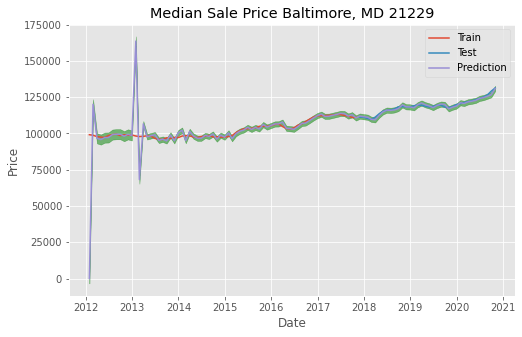

In [47]:
model.time_series_plot(21229,show_forecast=False);